In [6]:
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler

# Load the synthetic data
df = pd.read_csv("ansys_simulation_data.csv")

# Select inputs and outputs
X = df[['X_mm', 'Y_mm', 'Z_mm']].values
y = df[['Ux_mm', 'Uy_mm', 'Uz_mm']].values

# Normalize (important for training)
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)


In [7]:
import torch.nn as nn

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 3)
        )

    def forward(self, x):
        return self.net(x)


In [8]:
def physics_loss(model, x, E=2e11, nu=0.3):
    x.requires_grad_(True)
    u = model(x)

    lam = (E * nu) / ((1 + nu) * (1 - 2 * nu))
    mu = E / (2 * (1 + nu))

    grads = [torch.autograd.grad(u[:, i], x, grad_outputs=torch.ones_like(u[:, i]), create_graph=True)[0]
             for i in range(3)]

    # Divergence of displacement (∇·u)
    div_u = grads[0][:, 0] + grads[1][:, 1] + grads[2][:, 2]
    loss_pde = torch.mean(div_u ** 2)

    return loss_pde


In [ ]:
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(1000):
    optimizer.zero_grad()
    u_pred = model(X_tensor)
    
    data_loss = torch.mean((u_pred - y_tensor)**2)
    phys_loss = physics_loss(model, X_tensor)
    
    total_loss = data_loss + phys_loss
    total_loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Total Loss = {total_loss.item():.6f}")


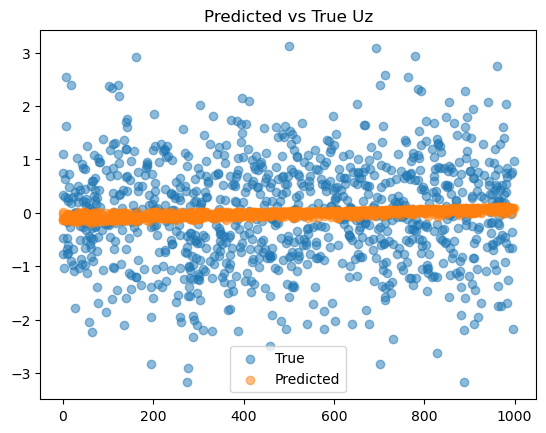

In [10]:
import matplotlib.pyplot as plt

u_pred = model(X_tensor).detach().numpy()
u_pred_real = y_scaler.inverse_transform(u_pred)

# Compare predicted vs actual Uz
plt.scatter(df['Z_mm'], df['Uz_mm'], label='True', alpha=0.5)
plt.scatter(df['Z_mm'], u_pred_real[:, 2], label='Predicted', alpha=0.5)
plt.title("Predicted vs True Uz")
plt.legend()
plt.show()


In [ ]:
import torch

torch.save(model.state_dict(), "pinn_model_weights.pth")


In [ ]:
torch.save(model, "pinn_full_model.pth")


In [9]:
model = PINN()  # You must define the model class before loading
model.load_state_dict(torch.load("pinn_model_weights.pth"))
model.eval()  # Set to inference mode


/var/folders/qg/fxxpnvjj7032y7p2j_l_b7mh0000gn/T/ipykernel_90808/531289103.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("pinn_model_w

PINN(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=3, bias=True)
  )
)

# MLOps



In [12]:
!pip install onnx


  Using cached onnx-1.17.0-cp312-cp312-macosx_12_0_universal2.whl.metadata (16 kB)
Using cached onnx-1.17.0-cp312-cp312-macosx_12_0_universal2.whl (16.7 MB)


In [13]:
import torch.onnx

# Example: Export the model to ONNX format
dummy_input = torch.randn(1, 3)  # Example input for the model, matching the input shape
torch.onnx.export(model, dummy_input, "pinn_model.onnx", input_names=['input'], output_names=['output'])


In [ ]:
!pip install torchviz


In [15]:
from torchviz import make_dot

# Create a visualization of the model
# Pass a sample input to generate the graph
sample_input = torch.randn(1, 3)
output = model(sample_input)
make_dot(output, params=dict(model.named_parameters())).render("model_architecture", format="png")


'model_architecture.png'

# hosting 

In [16]:
!pip install onnxruntime


In [17]:
import onnxruntime as ort
import numpy as np

# Load the ONNX model
onnx_model = ort.InferenceSession("pinn_model.onnx")

# Prepare input data (make sure it matches the input shape of your model)
input_data = np.random.randn(1, 3).astype(np.float32)

# Get model input names
input_name = onnx_model.get_inputs()[0].name

# Run the model
output = onnx_model.run(None, {input_name: input_data})

# Print the output
print(output)


[array([[0.23986712, 0.30756092, 0.2962149 ]], dtype=float32)]


In [20]:
!pip install onnx-tf


In [22]:
!pip install tensorflow-addons


ERROR: Could not find a version that satisfies the requirement tensorflow-addons (from versions: none)
ERROR: No matching distribution found for tensorflow-addons


In [23]:
import onnx
from onnx_tf.backend import prepare

# Load the ONNX model
onnx_model = onnx.load("pinn_model.onnx")

# Convert to TensorFlow
tf_rep = prepare(onnx_model)

# Run the model in TensorFlow
input_data = np.random.randn(1, 3).astype(np.float32)
output = tf_rep.run(input_data)

# Print output
print(output)


ModuleNotFoundError: No module named 'tensorflow_addons'

In [24]:
from fastapi import FastAPI
import onnxruntime as ort
import numpy as np
from pydantic import BaseModel

# FastAPI app
app = FastAPI()

# Load ONNX model
onnx_model = ort.InferenceSession("pinn_model.onnx")

# Define input data structure
class InputData(BaseModel):
    input: list

@app.post("/predict/")
async def predict(data: InputData):
    input_data = np.array(data.input, dtype=np.float32).reshape(1, -1)
    input_name = onnx_model.get_inputs()[0].name
    output = onnx_model.run(None, {input_name: input_data})
    return {"output": output[0].tolist()}

# Run with `uvicorn main:app --reload`


In [25]:
!uvicorn main:app --reload


INFO:     Will watch for changes in these directories: ['/Users/prahlad/Desktop/Projects/MCP/synthetic_sim_data']
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)
INFO:     Started reloader process [94260] using WatchFiles
ERROR:    Error loading ASGI app. Could not import module "main".
^C


In [ ]:
curl -X 'POST' \
  'http://127.0.0.1:8000/predict/' \
  -H 'Content-Type: application/json' \
  -d '{
  "input": [0.5, -0.2, 0.1]
}'
